In [1]:
"""Initialize all packages used"""
import time
import numpy as np
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 170
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import numpy.fft as fft
from scipy import signal

# Import packages
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import random
import string
import pandas as pd

In [2]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

In [3]:
def E_field_None(t, r):
    """
    E_field returns the electric field vector at time t at position r.
    """
    x, y, z = r[0], r[1], r[2]
            
    Ex = 0
    Ey = 0
    Ez = 0
    
    E_field = np.array([Ex, Ey, Ez])
    return(E_field)

In [4]:
def E_field_Constant(t, r):
    """
    E_field_Constant returns the electric field vector at time t at position r, for a constant electric field
    """
    x, y, z = r[0], r[1], r[2]
            
    Ex = - 1
    Ey = 0
    Ez = 0
    
    E_field = np.array([Ex, Ey, Ez])
    return(E_field)

In [5]:
def B_field_Radial(t, r):
    
    x, y, z = r[0], r[1], r[2]
    theta = np.arctan(y/z)
    
    Bo = 0.1
    Bx = 0
    By = Bo*np.sin(theta)/np.sqrt(r[0]**2 + r[2]**2)
    Bz = Bo*np.cos(theta)/np.sqrt(r[0]**2 + r[2]**2)
    
    B_field = np.array([Bx, By, Bz])
    return(B_field)

In [6]:
def E_field_Time(t, r):
    """
    E_field returns the electric field vector at time t at position r, for a time dependent field
    """
    global t_final
    x, y, z = r[0], r[1], r[2]
            
    Ex = 0
    Ey = 0.5*np.tanh(2*t/t_final)
    Ez = 0
    
    E_field = np.array([Ex, Ey, Ez])
    return(E_field)

In [7]:
def B_field_Space(t, r):
    """
    B_field returns the magnetic field vector at time t at position r, for a space-dependent field
    """
    x, y, z = r[0], r[1], r[2]
    
    Bx = 0.0
    By = 0.0
    Bz = 1/(1-0.1*r[0])
            
    B_field = np.array([Bx, By, Bz])
    return(B_field)

In [8]:
def B_field_Constant(t, r):
    """
    B_field returns the magnetic field vector at time t at position r for a constant magnetic field
    """
    x, y, z = r[0], r[1], r[2]
    
    Bx = 0.0
    By = 0.0
    Bz = 1.0
            
    B_field = np.array([Bx, By, Bz])
    return(B_field)

In [9]:
def E_field_Shock(t, r):
    """
    E_field returns the electric field vector at time t at position r, for an electric field with a shock
    """
    x, y, z = r[0], r[1], r[2]
    
    global comp_ratio
    global alpha
    
    a = alpha
    
    U1 = 1
    U2 = U1/comp_ratio
    DU = U1 - U2
    U = U1 - DU/2*(1 + np.tanh(x/a))
    
    DPhi = 0.9
    
    Ex = 0.0
    Ez = 0.0
    Ey = 0.1
    
    Ex = - 1/(2*a)*U*DU/(np.cosh(x/a)*np.cosh(x/a)) + 5*x/0.1*gaussian(x, 0, 0.1)
    Ex = - DPhi/(2*a)/(np.cosh(x/a)*np.cosh(x/a))
    
    wavelength = 10    
    k = 2*np.pi/wavelength
    if (x>=-a and x<=a):
        Ez = 0.1*np.cos(k*z)
    
    if (x>=-a and x<=a):
        Ey = 0.1 + 0.01*np.cos(k*z)
    E_field = np.array([Ex, Ey, Ez])
    return(E_field)

In [10]:
def B_field_Shock(t, r):
    """
    B_field returns the magnetic field vector at time t at position r, for a magnetic field with a shock
    """
    x, y, z = r[0], r[1], r[2]
    Bx = 0.0
    By = 0.0
    
    Bup = 1
    global comp_ratio
    global alpha
    
    B0 = 0.5*(comp_ratio + 1)*Bup
    B1 = 0.5*(comp_ratio - 1)*Bup
    a = alpha
    
    Bz = B0 + B1*np.tanh(x/a) #+ 5*gaussian(x, 0, 0.1)
    
    wavelength = 10
    k = 2*np.pi/wavelength
    
    if (x>=-a and x<=a):
        Bx = 0.0 + 1*np.cos(k*z)
    
    if (x>=-a and x<=a):
        By = 0.0 + 0.01*np.cos(k*z)
    
    B_field = np.array([Bx, By, Bz])
    return(B_field)

In [11]:
"""Initial conditions for integration, not used for shock"""
x0, y0, z0    =  0.0, 0.0, 0.0
v0x, v0y, v0z =   0.0, 1.0, 0.0
                                      
r0 = np.array([x0,  y0, z0])                    # initial condition for position
v0 = np.array([v0x, v0y, v0z])          

In [12]:
def Boris(r0, v0, t_initial, t_final, dt,B_field,E_field): 
    """The Boris algorithm"""
    
    global qm
    
    N = int(round((t_final-t_initial)/dt))      # total number of time steps
    t = np.linspace(t_initial, t_final, N+1)    # timeseries array
    
    r = np.zeros((N+1, 3))                      # particle position vector
    v = np.zeros((N+1, 3))                      # particle velocity vector 
    
    r[0, :] = r0     # initialize position
    v[0, :] = v0     # initialize velocity
    
    r[0, :] = r[0, :]
    rh = r[0, :] + 0.5*dt*v[0, :]   
    
    for i in range (len(t)-1):
        v_minus = v[i] - 0.5*dt*qm*E_field(t[i] + 0.5*dt, rh)
        B = B_field(t[i]+0.5*dt, rh,)
        Bx, By, Bz = B[0], B[1], B[2]

        bx = -Bx*qm*dt/2
        by = -By*qm*dt/2
        bz = -Bz*qm*dt/2
        b  = np.sqrt(bx*bx + by*by + bz*bz)

        # Miv was obtained analytically.
        Minv = 1/(1+b*b)*np.array([ [  1 + bx*bx,    bx*by + bz,     bx*bz - by]  ,\
                                    [ bx*by - bz,     1 + by*by,     bx + by*bz]  ,\
                                    [ by + bx*bz,   -bx + by*bz,      1 + bz*bz]  ])

        a = np.cross(v_minus, B)     # cross product between v_minus and B

        v_plus = v_minus - qm*dt*np.matmul(Minv, a)    # matrix multiplication

        v[i+1] = v_plus - 0.5*dt*qm*E_field(t[i]+0.5*dt, rh) # advance velocity
        r[i+1] = rh + 0.5*dt*v[i+1] # advance position
        rh = rh + dt*v[i+1]
        
    return r, v

In [13]:
def Analytical(r0,v0,t_initial,t_final,dt,B_field,E_field):
    """The analytical solution for the constant magnetic field"""
    global qm
    
    N = int(round((t_final-t_initial)/dt))      # total number of time steps
    t = np.linspace(t_initial, t_final, N+1)    # timeseries array
    
    r = np.zeros((N+1, 3))                      # particle position vector
    v = np.zeros((N+1, 3))                      # particle velocity vector 
    
    r[0, :] = r0     # initialize position
    v[0, :] = v0     # initialize velocity
    for i in range (len(t)-1):
        r[i+1] = [1-np.cos(t[i]),np.sin(t[i]),0]
        v[i+1] = [np.sin(t[i]),np.cos(t[i]),0]
    return r,v

In [14]:
def RK4(r0, v0, t_initial, t_final, dt,B_field,E_field):
    """RK4 algorithm"""
    global qm
    
    N = int(round((t_final-t_initial)/dt))      # total number of time steps
    t = np.linspace(t_initial, t_final, N+1)    # timeseries array
    
    r = np.zeros((N+1, 3))                      # particle position vector
    v = np.zeros((N+1, 3))                      # particle velocity vector 
    
    r[0, :] = r0     # initialize position
    v[0, :] = v0    # initialize velocity
    
    def func(tau, x, xdot):
        B = B_field(tau, x)
        vB = np.cross(xdot, B)
        return -qm*(E_field(tau, x)+vB)
    
    for i in range(0, len(t)-1):
        k1x = v[i]
        k1v = func(t[i],r[i],v[i])
        k2x = v[i]+dt*k1v/2
        k2v = func(t[i] +dt/2,r[i]+dt*k1x/2,v[i]+dt*k1v/2)
        k3x = v[i]+dt*k2v/2
        k3v = func(t[i] +dt/2,r[i]+dt*k2x/2,v[i]+dt*k2v/2)
        k4x = v[i]+dt*k3v
        k4v = func(t[i]+dt,r[i]+dt*k3x,v[i]+dt*k3v)
        r[i+1] = r[i] + dt/6 * (k1x+2*k2x+2*k3x+k4x)
        v[i+1] = v[i] + dt/6 * (k1v+2*k2v+2*k3v+k4v)
        
    return r, v

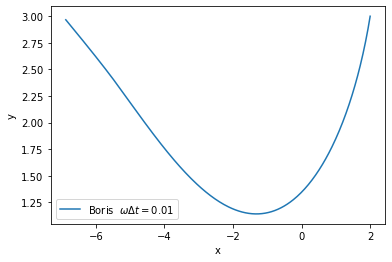

In [21]:
t_final = np.pi
N = int(round((t_final-t_initial)/dt))      # total number of time steps
t = np.linspace(t_initial, t_final, N+1) 
fig, ax = plt.subplots()
r2, v2 = Boris(np.array([2, 3, 3]), np.array([-1, -2, 0]), t_initial, t_final, 0.01,B_field_Radial,E_field_Constant)
r = r2
v = v2
ax.plot(r[:, 0], r[:, 1],label = "Boris $\ \omega \Delta t = 0.01$")
#ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.legend()

In [22]:
"""All constants used in integration"""
q = -1                                     # particle charge
m = 1 
comp_ratio = 4   # shock compression ratio
alpha = 1   # particle mass
qm = q/m                                      # charge to mass ratio
dt = 0.01                                     # timestep
t_initial = 0                                 # initial time
t_final = np.pi                            # final time

Text(0.5, 0, 'z-direction')

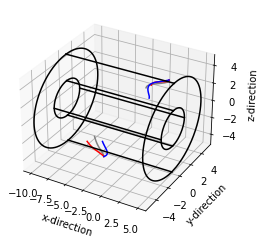

In [23]:
ax = plt.axes(projection='3d')
r, v = Boris(np.array([2, 3, 3]), np.array([0.5*1, -0.5*1, -0.5*0.1]), t_initial, t_final, 0.01,B_field_Radial,E_field_Constant)
r2, v2 = Boris(np.array([2, 3, 3]), np.array([0.5*1, -0.5*0.5, -0.5*0.1]), t_initial, t_final, 0.01,B_field_Radial,E_field_Constant)
r3, v3 = Boris(np.array([2, 3, 3]), np.array([-0.5*1, -0.5*1, -0.5*0.1]), t_initial, t_final, 0.01,B_field_Radial,E_field_Constant)
ax.plot3D(r[:, 0], r[:, 1], r[:, 2], 'gray')
ax.plot3D(r2[:, 0], r2[:, 1], r2[:, 2], 'red')
ax.plot3D(r3[:, 0], r3[:, 1], r3[:, 2], 'blue')
r4, v4 = Boris(np.array([-2, -3, -3]), np.array([-0.5*1, 0.5*1, 0.5*0.1]), t_initial, t_final, 0.01,B_field_Radial,E_field_Constant)
r5, v5 = Boris(np.array([-2, -3, -3]), np.array([-0.5*1, 0.5*0.5, 0.5*0.1]), t_initial, t_final, 0.01,B_field_Radial,E_field_Constant)
r6, v6 = Boris(np.array([-2, -3, -3]), np.array([0.5*1, 0.5*1, 0.5*0.1]), t_initial, t_final, 0.01,B_field_Radial,E_field_Constant)
ax.plot3D(r4[:, 0], r4[:, 1], r4[:, 2], 'gray')
ax.plot3D(r5[:, 0], r5[:, 1], r5[:, 2], 'red')
ax.plot3D(r6[:, 0], r6[:, 1], r6[:, 2], 'blue')
zline1 = np.linspace(-5,5,len(r[:,0]/2))
zline2 = np.linspace(-5,5,len(r[:,0]/2))
xline = np.repeat(5,len(r[:,0]))
yline1 = -np.sqrt(25-zline1**2)
yline2 = np.sqrt(25-zline1**2)
ax.plot3D(xline, yline1, zline1, 'black')
ax.plot3D(xline, yline2, zline2, 'black')
ax.plot3D(np.linspace(-10,5,2),np.repeat(0,2),np.repeat(5,2),"black")
ax.plot3D(np.linspace(-10,5,2),np.repeat(0,2),np.repeat(-5,2),"black")
#ax.plot3D(np.linspace(-10,5,2),np.repeat(5,2),np.repeat(0,2),"black")
#ax.plot3D(np.linspace(-10,5,2),np.repeat(-5,2),np.repeat(0,2),"black")
zline1 = np.linspace(-2,2,len(r[:,0]/2))
zline2 = np.linspace(-2,2,len(r[:,0]/2))
xline = np.repeat(5,len(r[:,0]))
yline1 = -np.sqrt(4-zline1**2)
yline2 = np.sqrt(4-zline1**2)
ax.plot3D(xline, yline1, zline1, 'black')
ax.plot3D(xline, yline2, zline2, 'black')
ax.plot3D(np.linspace(-10,5,2),np.repeat(0,2),np.repeat(2,2),"black")
ax.plot3D(np.linspace(-10,5,2),np.repeat(0,2),np.repeat(-2,2),"black")
ax.plot3D(np.linspace(-10,5,2),np.repeat(2,2),np.repeat(0,2),"black")
ax.plot3D(np.linspace(-10,5,2),np.repeat(-2,2),np.repeat(0,2),"black")
zline1 = np.linspace(-2,2,len(r[:,0]/2))
zline2 = np.linspace(-2,2,len(r[:,0]/2))
xline = np.repeat(-10,len(r[:,0]))
yline1 = -np.sqrt(4-zline1**2)
yline2 = np.sqrt(4-zline1**2)
ax.plot3D(xline, yline1, zline1, 'black')
ax.plot3D(xline, yline2, zline2, 'black')
zline1 = np.linspace(-5,5,len(r[:,0]/2))
zline2 = np.linspace(-5,5,len(r[:,0]/2))
xline = np.repeat(-10,len(r[:,0]))
yline1 = -np.sqrt(25-zline1**2)
yline2 = np.sqrt(25-zline1**2)
ax.plot3D(xline, yline1, zline1, 'black')
ax.plot3D(xline, yline2, zline2, 'black')
ax.set_xlabel("x-direction")
ax.set_ylabel("y-direction")
ax.set_zlabel("z-direction")

In [24]:
def B_field_Radial(t, r):
    
    x, y, z = r[0], r[1], r[2]
    theta = np.arctan(y/z)
    
    Bo = 2
    Bx = 0
    By = Bo*np.sin(theta)/np.sqrt(r[0]**2 + r[2]**2)
    Bz = Bo*np.cos(theta)/np.sqrt(r[0]**2 + r[2]**2)
    
    B_field = np.array([Bx, By, Bz])
    return(B_field)

Text(0.5, 0, 'z-direction')

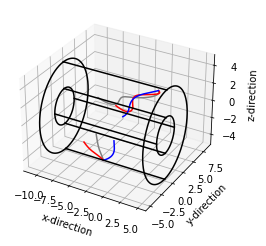

In [25]:
ax = plt.axes(projection='3d')
r, v = Boris(np.array([2, 3, 3]), np.array([1, -1, -0.1]), t_initial, 2*t_final, 0.01,B_field_Radial,E_field_Constant)
r2, v2 = Boris(np.array([2, 3, 3]), np.array([1, -0.5, -0.1]), t_initial, 2*t_final, 0.01,B_field_Radial,E_field_Constant)
r3, v3 = Boris(np.array([2, 3, 3]), np.array([-1, -1, -0.1]), t_initial, t_final, 0.01,B_field_Radial,E_field_Constant)
ax.plot3D(r[:, 0], r[:, 1], r[:, 2], 'gray')
ax.plot3D(r2[:, 0], r2[:, 1], r2[:, 2], 'red')
ax.plot3D(r3[:, 0], r3[:, 1], r3[:, 2], 'blue')
r4, v4 = Boris(np.array([-2, -3, -3]), np.array([-1, 1, 0.1]), t_initial, t_final, 0.01,B_field_Radial,E_field_Constant)
r5, v5 = Boris(np.array([-2, -3, -3]), np.array([-1, 0.5, 0.1]), t_initial, t_final, 0.01,B_field_Radial,E_field_Constant)
r6, v6 = Boris(np.array([-2, -3, -3]), np.array([1, 1, 0.1]), t_initial, t_final, 0.01,B_field_Radial,E_field_Constant)
ax.plot3D(r4[:, 0], r4[:, 1], r4[:, 2], 'gray')
ax.plot3D(r5[:, 0], r5[:, 1], r5[:, 2], 'red')
ax.plot3D(r6[:, 0], r6[:, 1], r6[:, 2], 'blue')
zline1 = np.linspace(-5,5,len(r[:,0]/2))
zline2 = np.linspace(-5,5,len(r[:,0]/2))
xline = np.repeat(5,len(r[:,0]))
yline1 = -np.sqrt(25-zline1**2)
yline2 = np.sqrt(25-zline1**2)
ax.plot3D(xline, yline1, zline1, 'black')
ax.plot3D(xline, yline2, zline2, 'black')
ax.plot3D(np.linspace(-10,5,2),np.repeat(0,2),np.repeat(5,2),"black")
ax.plot3D(np.linspace(-10,5,2),np.repeat(0,2),np.repeat(-5,2),"black")
#ax.plot3D(np.linspace(-10,5,2),np.repeat(5,2),np.repeat(0,2),"black")
#ax.plot3D(np.linspace(-10,5,2),np.repeat(-5,2),np.repeat(0,2),"black")
zline1 = np.linspace(-2,2,len(r[:,0]/2))
zline2 = np.linspace(-2,2,len(r[:,0]/2))
xline = np.repeat(5,len(r[:,0]))
yline1 = -np.sqrt(4-zline1**2)
yline2 = np.sqrt(4-zline1**2)
ax.plot3D(xline, yline1, zline1, 'black')
ax.plot3D(xline, yline2, zline2, 'black')
ax.plot3D(np.linspace(-10,5,2),np.repeat(0,2),np.repeat(2,2),"black")
ax.plot3D(np.linspace(-10,5,2),np.repeat(0,2),np.repeat(-2,2),"black")
ax.plot3D(np.linspace(-10,5,2),np.repeat(2,2),np.repeat(0,2),"black")
ax.plot3D(np.linspace(-10,5,2),np.repeat(-2,2),np.repeat(0,2),"black")
zline1 = np.linspace(-2,2,len(r[:,0]/2))
zline2 = np.linspace(-2,2,len(r[:,0]/2))
xline = np.repeat(-10,len(r[:,0]))
yline1 = -np.sqrt(4-zline1**2)
yline2 = np.sqrt(4-zline1**2)
ax.plot3D(xline, yline1, zline1, 'black')
ax.plot3D(xline, yline2, zline2, 'black')
zline1 = np.linspace(-5,5,len(r[:,0]/2))
zline2 = np.linspace(-5,5,len(r[:,0]/2))
xline = np.repeat(-10,len(r[:,0]))
yline1 = -np.sqrt(25-zline1**2)
yline2 = np.sqrt(25-zline1**2)
ax.plot3D(xline, yline1, zline1, 'black')
ax.plot3D(xline, yline2, zline2, 'black')
ax.set_xlabel("x-direction")
ax.set_ylabel("y-direction")
ax.set_zlabel("z-direction")

In [26]:
def Func_general1(i,j,k):
    return np.array([np.cos(np.pi*i/100) + np.sin(np.pi*j/100) + -1 + k/50, np.cos(np.pi*i/100) + np.sin(np.pi*j/100) + -1 + k/50, np.cos(np.pi*i/100) + np.sin(np.pi*j/100) + -1 + k/50])

In [27]:
def Func_general_1D(i,j,k):
    return np.cos(np.pi*i/100) + np.sin(np.pi*j/100) + -1 + k/50

In [28]:
def Func_general2(i,j,k):
    return np.array([np.sin(np.pi*i/100) + np.cos(np.pi*j/100) + -1 + k/50, np.sin(np.pi*i/100) + np.cos(np.pi*j/100) + -1 + k/50, np.sin(np.pi*i/100) + np.cos(np.pi*j/100) + -1 + k/50])

In [29]:
def Grider(func,dens):
    M = []
    for k in range(0,dens):
##Construct grid of electric field 100x100.
        E = []
        for i in range(0,dens):
            temp_out = []
            for j in range(0,dens):
                temp_out.append(func(i,j,k))
            E.append(temp_out)
        M.append(E)
    return M

In [30]:
##Credits to Smitha Dinesh Semwal
def getClosest(val1, val2, target):
 
    if (target - val1 >= val2 - target):
        return val2
    else:
        return val1

In [31]:
##Credits to Smitha Dinesh Semwal
def findClosest(arr, target):
    n = len(arr)
    # Corner cases
    if (target <= arr[0]):
        return arr[0]
    if (target >= arr[n - 1]):
        return arr[n - 1]
 
    # Doing binary search
    i = 0; j = n; mid = 0
    while (i < j):
        mid = int((i + j) / 2)
        
        if (arr[mid] == target):
            return arr[mid]
 
        # If target is less than array
        # element, then search in left
        if (target < arr[mid]) :
 
            # If target is greater than previous
            # to mid, return closest of two
            if (mid > 0 and target > arr[mid - 1]):
                return getClosest(arr[mid - 1], arr[mid], target)
 
            # Repeat for left half
            j = mid
         
        # If target is greater than mid
        else :
            if (mid < n - 1 and target < arr[mid + 1]):
                return getClosest(arr[mid], arr[mid + 1], target)
                 
            # update i
            i = mid + 1
         
    # Only single element left after search
    return arr[mid]

In [32]:
def Finder_Getter(x,y,z,x_arr,y_arr,z_arr,M):
    x_1st = int(findClosest(x_arr,x))
    x_arr = np.delete(x_arr,x_1st)
    x_2nd = int(findClosest(x_arr,x))
    
    
    y_1st = int(findClosest(y_arr,y))
    y_arr = np.delete(y_arr,y_1st)
    y_2nd = int(findClosest(y_arr,y))
    
    
    z_1st = int(findClosest(z_arr,z))
    z_arr = np.delete(z_arr,z_1st)
    z_2nd = int(findClosest(z_arr,z))
    print(z_2nd)
    
    #So now, we have a 8 point cube to constrain the point, that is composed of points
    111, 112, 122, 211, 121, 212, 221, 222
    E_1 = M[x_1st-1][y_1st-1][z_1st-1]
    E_2 = M[x_1st-1][y_1st-1][z_2nd-1]
    E_3 = M[x_1st-1][y_2nd-1][z_2nd-1]
    E_4 = M[x_2nd-1][y_1st-1][z_1st-1]
    E_5 = M[x_1st-1][y_2nd-1][z_1st-1]
    E_6 = M[x_2nd-1][y_1st-1][z_2nd-1]
    E_7 = M[x_2nd-1][y_2nd-1][z_1st-1]
    E_8 = M[x_2nd-1][y_2nd-1][z_2nd-1]
    
    E_averaged = (E_1+E_2+E_3+E_4+E_5+E_6+E_7+E_8)/8
    return E_averaged

In [33]:
def Visualization(M,M_range_zslice):
    
    for i in M_range_zslice:
        E = M[i]
##Constructing string of 100 characters to do the pandas construction
        res = ''.join(random.choices(string.ascii_uppercase +
                                 string.digits, k = 100))
##Constructing pandas dataframe 
        K = pd.DataFrame(E, columns=list(res))
        data = K
        df=data.unstack().reset_index()
        df.columns=["X","Y","Z"]
# And transform the old column name in something numeric
        df['X']=pd.Categorical(df['X'])
        df['X']=df['X'].cat.codes
        mpl.rcParams['figure.dpi']= 50
# to Add a color bar which maps values to colors.
        fig = plt.figure()
        fig = plt.figure(figsize=(20, 10))
        ax = fig.gca(projection='3d')
        surf=ax.plot_trisurf(df['Y'], df['X'], df['Z'], cmap=plt.cm.viridis, linewidth=10)
        fig.colorbar(surf, shrink=1, aspect=10)
        plt.xlabel("x-direction")
        plt.ylabel("y-direction")
        plt.show() 

2


<Figure size 300x200 with 0 Axes>

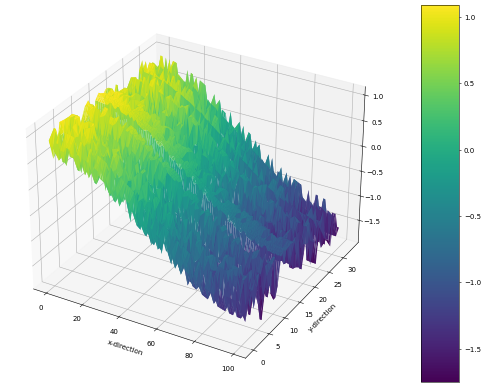

In [34]:
#General outlay of Electric Field
E_field = Grider(Func_general_1D,100)
Finder_Getter(4.7,2.3,1.3,np.linspace(0,100,100),np.linspace(0,100,100),np.linspace(0,100,100),E_field)
Visualization(E_field,[5])

In [35]:
Finder_Getter(4.7,2.3,1.3,np.linspace(0,100,100),np.linspace(0,100,100),np.linspace(0,100,100),E_field)

2


0.08447202393606573

In [36]:
def Boris_Grid(r0, v0, t_initial, t_final, dt,B,E): 
    """The Boris algorithm"""
    
    global qm
    
    N = int(round((t_final-t_initial)/dt))      # total number of time steps
    t = np.linspace(t_initial, t_final, N+1)    # timeseries array
    
    r = np.zeros((N+1, 3))                      # particle position vector
    v = np.zeros((N+1, 3))                      # particle velocity vector 
    
    r[0, :] = r0     # initialize position
    v[0, :] = v0     # initialize velocity
    
    r[0, :] = r[0, :]
    rh = r[0, :] + 0.5*dt*v[0, :]   
    print(len(t))
    
    for i in range (len(t)-1):
        E_loc = Finder_Getter(rh[0],rh[1],rh[2],np.linspace(0,len(E),len(E)),np.linspace(0,len(E),len(E)),
                                                 np.linspace(0,len(E),len(E)),E)
        v_minus = v[i] - 0.5*dt*qm*E_loc
        B_loc = Finder_Getter(rh[0],rh[1],rh[2],np.linspace(0,len(B),len(B)),np.linspace(0,len(B),len(B)),
                                                 np.linspace(0,len(B),len(B)),B)
        Bx, By, Bz = B_loc[0], B_loc[1], B_loc[2]

        bx = -Bx*qm*dt/2
        by = -By*qm*dt/2
        bz = -Bz*qm*dt/2
        b  = np.sqrt(bx*bx + by*by + bz*bz)

        # Miv was obtained analytically.
        Minv = 1/(1+b*b)*np.array([ [  1 + bx*bx,    bx*by + bz,     bx*bz - by]  ,\
                                    [ bx*by - bz,     1 + by*by,     bx + by*bz]  ,\
                                    [ by + bx*bz,   -bx + by*bz,      1 + bz*bz]  ])

        a = np.cross(v_minus, B_loc)     # cross product between v_minus and B

        v_plus = v_minus - qm*dt*np.matmul(Minv, a)    # matrix multiplication

        v[i+1] = v_plus - 0.5*dt*qm*E_loc # advance velocity
        r[i+1] = rh + 0.5*dt*v[i+1] # advance position
        rh = rh + dt*v[i+1]
        print(i)
        
    return r, v

In [ ]:
E = Grider(Func_general1,100)
B = Grider(Func_general2,100)

In [ ]:
B[4]

In [ ]:
N = int(round((0.25*t_final-t_initial)/dt))      # total number of time steps
t = np.linspace(t_initial, 0.25*t_final, N+1)
mpl.rcParams['figure.dpi']= 150
plt.plot(t,r)
plt.xlabel("Time τ non-dimensional")
plt.ylabel("Position r non-dimensional")